Perturbation intro plots
========================



## Goal



The goal of this notebook is to make plots for the perturbation figure of the paper. Namely:

-   Example perturbed trajectories
-   Demo plots for quantifying the likelihood of walking
-   Speed vs perturbation strength plot

This is for Figure 4 of the paper

The notebook should be set up so that running it from top to bottom makes all the figure sublayouts.



## Setup



In [1]:
project_path = "/home/lili/research/tuthill/layered-walking"
data_path = '/home/lili/data/tuthill/models/sls_runs'

In [2]:
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
import pandas as pd
from scipy import signal
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from glob import glob
import pickle

In [3]:
import sys
sys.path.append(project_path)
from tools.angle_functions import anglesTG as angle_names_1leg
from tools.angle_functions import legs
from tools.angle_functions import make_fly_video, angles_to_pose_names
from tools.trajgen_tools import WalkingData
from tools.dist_tools import DistType

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (7.5, 2)

In [5]:
xvals = np.linspace(-np.pi, np.pi)
def get_phase(ang):
    m = np.median(ang, axis=0)
    s = np.std(ang, axis=0)
    s[s == 0] = 1
    dm = (ang - m) / s
    phase = np.arctan2(-dm[:,1], dm[:,0])
    return phase

def phase_align_poly(ang, extra=None, order=5):
    topredict = ang
    if extra is not None:
        topredict = np.hstack([ang, extra])
    means = np.full((len(xvals), topredict.shape[1]), np.nan)
    stds = np.full((len(xvals), topredict.shape[1]), np.nan)
    if len(ang) < 50: # not enough data
        return means, stds
    phase = get_phase(ang)
    # pcs = np.vstack([np.cos(phase), np.sin(phase)]).T
    b = np.vstack([np.cos(i * phase + j) for i in range(order) for j in [0, np.pi/2]]).T
    xcs = np.vstack([np.cos(i * xvals + j) for i in range(order) for j in [0, np.pi/2]]).T
    for i in range(topredict.shape[1]):
        cc = np.isfinite(topredict[:,i])
        model = sm.OLS(topredict[cc,i], b[cc]).fit()
        means[:,i] = model.predict(xcs)
        s, upper,lower = wls_prediction_std(model, xcs)
        stds[:,i] = s
    return means, stds

In this notebook, we only load the actuation delays of 30ms, and sensory delays of 10ms (built-in for this dataset).



In [6]:
fname_pat = os.path.join(data_path, 'delays_stats_subang_v9_actuate_*.pkl')
fnames = sorted(glob(fname_pat))

conditions = []
angles = []
derivs = []
accels = []

for fname in tqdm(fnames, ncols=70):
    # d = np.load(fname, allow_pickle=True)
    with open(fname, 'rb') as f:
        d = pickle.load(f)

    angle_names = d['angleNames'][0]

    for i, cond in enumerate(d['conditions']):
        if not np.isclose(cond['actDelay'], 0.030):
            continue
        ang = d['angle'][i]
        deriv = signal.savgol_filter(ang, 5, 2, deriv=1, axis=0)
        accel = signal.savgol_filter(deriv, 5, 2, deriv=1, axis=0)
        conditions.append(cond)
        angles.append(ang)
        derivs.append(deriv)
        accels.append(accel)

100%|███████████████████████████████| 132/132 [07:52<00:00,  3.58s/it]


In [7]:
speeds = np.array([x['context'] for x in conditions])
dist_types = np.array([x['dist'].value for x in conditions])
act_delays = np.array([x['actDelay'] for x in conditions])
max_velocities = np.array([x['maxVelocity'] for x in conditions])
angle_names = list(angle_names)

In [8]:
perturb_ranges = {
    'before': (0, 300),
    'during': (300, 600),
    'after': (600, 900)
}

In [9]:
conditions[:5]

[{'context': [6, 0, 0],
  'offset': 0,
  'dist': <DistType.IMPULSE: 7>,
  'maxVelocity': 0.0,
  'actDelay': 0.03},
 {'context': [6, 0, 0],
  'offset': 1,
  'dist': <DistType.IMPULSE: 7>,
  'maxVelocity': 0.0,
  'actDelay': 0.03},
 {'context': [6, 0, 0],
  'offset': 2,
  'dist': <DistType.IMPULSE: 7>,
  'maxVelocity': 0.0,
  'actDelay': 0.03},
 {'context': [6, 0, 0],
  'offset': 3,
  'dist': <DistType.IMPULSE: 7>,
  'maxVelocity': 0.0,
  'actDelay': 0.03},
 {'context': [6, 0, 0],
  'offset': 0,
  'dist': <DistType.IMPULSE: 7>,
  'maxVelocity': 1.25,
  'actDelay': 0.03}]

In [10]:
fname = '/home/lili/data/tuthill/models/models_sls/data_subang_5.pickle'
wd = WalkingData(fname)

In [11]:
wd.bout_context

array([[  4.246732  ,   0.7071299 ,   0.3955671 ],
       [  2.5441482 ,   3.387733  ,   1.0246041 ],
       [  2.3452914 ,  -0.44610858,  -0.20245193],
       ...,
       [  6.904698  ,   3.0903168 ,   3.0456958 ],
       [  5.8905787 ,  -4.7177234 ,   1.9700806 ],
       [  8.232974  , -12.293827  ,  -0.86852646]], dtype=float32)

In [12]:
fancy_angle_names = {
    'C_flex': 'femur-tibia\nflexion',
    'A_rot': 'coxa\nrotation',
    'A_abduct': 'body-coxa\nflexion',
    'B_flex': 'coxa-femur\nflexion',
    'B_rot': 'femur\nrotation'
}

## Example time series



For the example plots, we want to show a few speeds with impulse and poisson perturbations.

I think we talked about reorganizing these figures. I think actually it would help me to have a better sense of what to plot to draw a sketch of the remaining figures.
Then I can focus on implementing them in this and other notebooks



In [13]:
plot_speeds = [[8, 0, 0], [10, 0, 0], [12, 0, 0]]

{'context': [8, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [10, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [12, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [8, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [10, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [12, 0, 0], 'offset': 3, 'dist': <DistType.POISSON_GAUSSIAN: 6>, 'maxVelocity': 1.875, 'actDelay': 0.03}
{'context': [8, 0, 0], 'offset': 3, 'dist': <DistType.IMPULSE: 7>, 'maxVelocity': 3.75, 'actDelay': 0.03}
{'context': [10, 0, 0], 'offset': 3, 'dist': <DistType.IMPULSE: 7>, 'maxVelocity': 3.75, 'actDelay': 0.03}
{'context': [12, 0, 0], 'offset': 3, 'dist': <DistType.IMPULSE: 7>, 'maxVelocity': 3.75

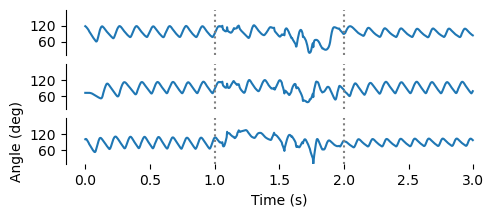

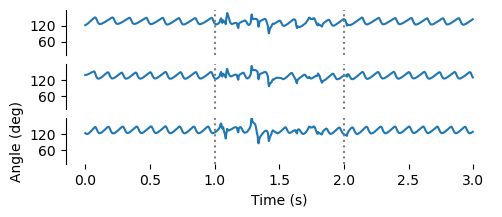

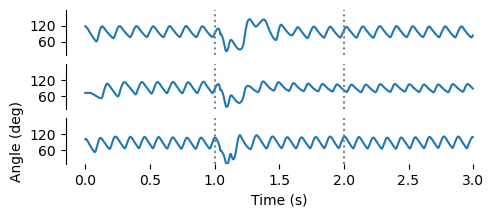

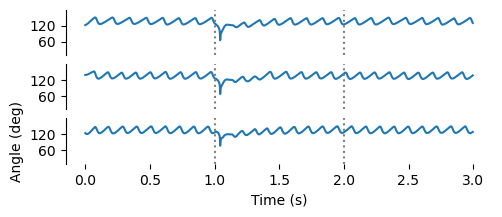

In [14]:
angnames = ['R1C_flex', 'L2B_rot']
dists = ['poisson', 'impulse']
dist_values = {'poisson': DistType.POISSON_GAUSSIAN.value,
               'impulse': DistType.IMPULSE.value}

for dist in dists:
    dist_value = dist_values[dist]
    for angname in angnames:
        ix_ang = angle_names.index(angname)

        plt.figure(figsize=(5.5, 2))
        for i in range(len(plot_speeds)):
            plt.subplot(3, 1, i+1)
            ixs = np.where(np.all(speeds == plot_speeds[i], axis=1)
                           & (dist_types == dist_value)
                           & np.isclose(act_delays, 0.030))[0]
            ix_bout = ixs[15]
            print(conditions[ix_bout])
            ang = angles[ix_bout][:, ix_ang]
            t = np.arange(len(ang))/300.0
            plt.plot(t, ang)
            plt.axvline(t[300], color='gray', linestyle='dotted')
            plt.axvline(t[600], color='gray', linestyle='dotted')
            plt.ylim(10, 180)
            plt.yticks([60, 120])
            if i != 2:
                plt.xticks(ticks=[])

        sns.despine(bottom=True)
        plt.ylabel("Angle (deg)")
        plt.xlabel("Time (s)")

        plt.savefig('plots/perturb_intro_trace_{}_{}.pdf'.format(angname, dist),
                    bbox_inches = "tight")

## principal component metric



In [15]:
full_L = []
bnums = wd._get_minlen_bnums(300)
for bnum in bnums:
    bout = wd.get_bnum(bnum)
    angs = np.hstack([bout['angles'][leg] for leg in legs])
    full_L.append(angs)
full = np.vstack(full_L)

full_sc = np.hstack([np.sin(np.deg2rad(full)),
                     np.cos(np.deg2rad(full))])

pca = PCA(n_components=2)
pcs = pca.fit_transform(full_sc)

subixs = np.random.choice(pcs.shape[0], size=100000, replace=False)
kde = gaussian_kde(pcs[subixs,:2].T)

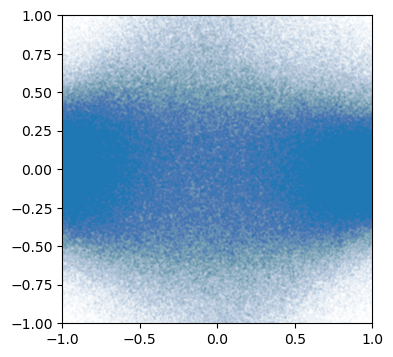

In [16]:
plt.figure(figsize=(4, 4))
plt.scatter(pcs[:,0], pcs[:,1], s=1, alpha=0.01)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.savefig('plots/demo_pca.pdf', bbox_inches='tight')

/tmp/ipykernel_1158782/1223795816.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable)


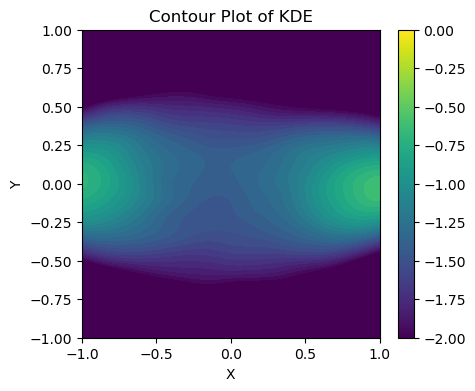

In [17]:
xgrid = np.linspace(-1.0, 1.0, 200)
ygrid = np.linspace(-1.0, 1.0, 200)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate the KDE at each point on the grid
Z = np.reshape(kde.logpdf(positions).T, X.shape)

# Create the contour plot
plt.figure(figsize=(4.8,4))
norm = plt.Normalize(vmin=-2, vmax=0)
cmap = plt.get_cmap('viridis')
mappable = plt.cm.ScalarMappable(norm, cmap)
CS = plt.contourf(X, Y, Z, cmap='viridis', levels=100, norm=norm)
plt.colorbar(mappable)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour Plot of KDE')
plt.savefig('plots/kde_plot.pdf', bbox_inches = "tight")

{'context': [6, 0, 0], 'offset': 2, 'dist': <DistType.IMPULSE: 7>, 'maxVelocity': 2.5, 'actDelay': 0.03}
-403.7735445993169
-508.33616769997565
-427.94057083576604


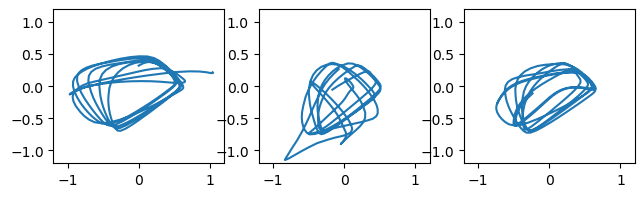

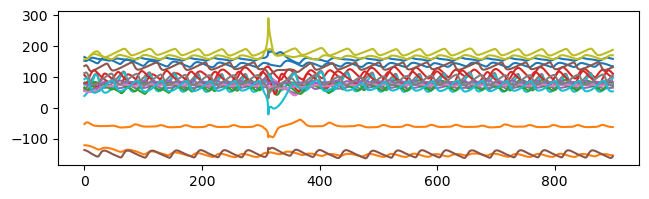

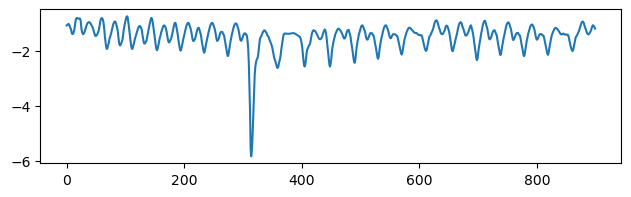

In [18]:
ix_bout = 10
print(conditions[ix_bout])
ang = angles[ix_bout]
ang_sc = np.hstack([np.sin(np.deg2rad(ang)),
                    np.cos(np.deg2rad(ang))])

pcs = pca.transform(ang_sc)

plt.subplot(1, 3, 1)
plt.plot(pcs[:300,0], pcs[:300,1])
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.subplot(1, 3, 2)
plt.plot(pcs[300:600,0], pcs[300:600,1])
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.subplot(1, 3, 3)
plt.plot(pcs[600:,0], pcs[600:,1])
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

pdfs = kde.logpdf(pcs[:, :2].T)
# plt.plot(pdfs)

print(np.sum(pdfs[0:300]))
print(np.sum(pdfs[300:600]))
print(np.sum(pdfs[600:900]))

plt.figure()
plt.plot(ang)

plt.figure()
plt.plot(pdfs)

## speed vs perturbation strength plots



First we map out the logpdf of each bout.



In [19]:
angles_sc = np.dstack([np.sin(np.deg2rad(angles)),
                       np.cos(np.deg2rad(angles))])

angles_sc_flat = angles_sc.reshape(-1, angles_sc.shape[-1])

pcs = np.full((angles_sc_flat.shape[0], 2), np.nan)
good = np.all(np.isfinite(angles_sc_flat), axis=1)
pcs[good] = pca.transform(angles_sc_flat[good])
# pcs = pca.transform(angles_sc_flat)

pdfs_flat = np.full(len(pcs), -2.5)
step = 500
for i in trange(0, len(pcs), step, ncols=70):
    check = np.all(np.isfinite(pcs[i:i+step]), axis=1)
    pdfs_flat[i:i+step][check] = kde.logpdf(pcs[i:i+step, :2][check].T)

pdfs_shaped = pdfs_flat.reshape(angles_sc.shape[:2])

100%|███████████████████████████████| 908/908 [18:36<00:00,  1.23s/it]


### plot for continuous perturbation



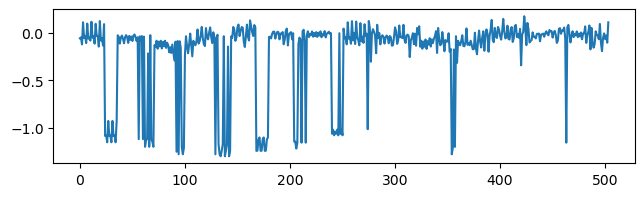

In [20]:
before = np.nanmean(pdfs_shaped[:, :300], axis=1)
during = np.nanmean(pdfs_shaped[:, 300:600], axis=1)
after = np.nanmean(pdfs_shaped[:, 600:900], axis=1)

# plt.plot(before)
# plt.plot(during - before)
plt.plot(after - before)

In [21]:
dd = pd.DataFrame({"delay": act_delays,
                   "dist": dist_types,
                   "forward_speed": speeds[:, 0],
                   "perturbation": max_velocities,
                   "during_logpdf": during,
                   "after_logpdf": after,
                   "during_diff_logpdf": during-before,
                   "after_diff_logpdf": after-before,
                   "before_logpdf": before})

dsub = dd[dd['dist'] == DistType.POISSON_GAUSSIAN.value]
dgroup = dsub.groupby(['forward_speed', 'perturbation']).mean()

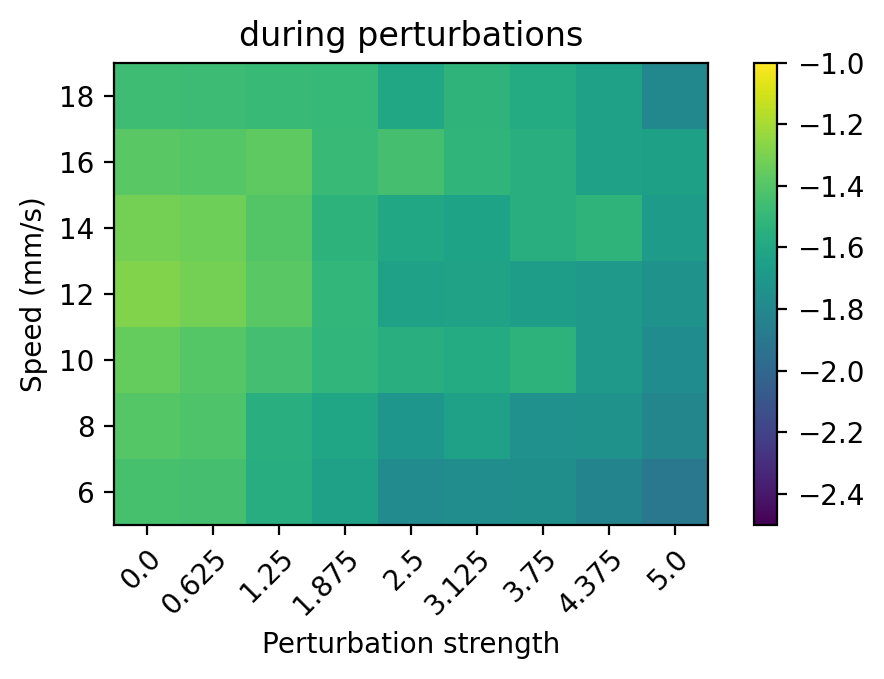

In [22]:
to_plot  = [
#     ("during - before perturbations", "during_diff_logpdf"),
#             ("after - before perturbations", "after_diff_logpdf"),
#             ("before perturbations", "before_logpdf"),
            ("during perturbations", "during_logpdf"),
#             ("after perturbations", "after_logpdf")
            ]


for (name, key) in to_plot:
    dimg = dgroup.reset_index().pivot(columns='perturbation', index='forward_speed', values=key)
    plt.close('all')
    plt.figure(figsize=(6, 3), dpi=200)
    if "diff" in key:
        plt.imshow(dimg, vmin=-2, vmax=0)
    else:
        plt.imshow(dimg, vmin=-2.5, vmax=-1)

    ax = plt.gca()
    ax.set_xticks(np.arange(len(dimg.columns)), labels=dimg.columns)
    ax.set_yticks(np.arange(len(dimg.index)), labels=np.int32(dimg.index))

    ax.invert_yaxis()

    ax.set_xlabel("Perturbation strength")
    ax.set_ylabel("Speed (mm/s)")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.colorbar()
    plt.title(name)

    plt.savefig('plots/fig_speeds_perturbation_continuous_logpdf_{}.pdf'.format(key), bbox_inches = "tight")

### plot for impulse perturbation



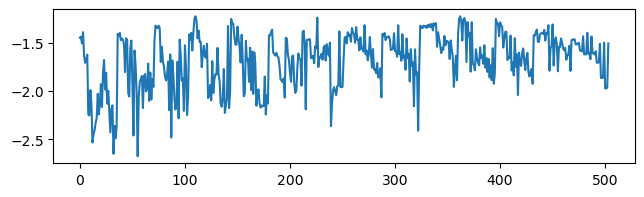

In [23]:
before = np.nanmean(pdfs_shaped[:, :300], axis=1)
during = np.nanmean(pdfs_shaped[:, 305:400], axis=1)
after = np.nanmean(pdfs_shaped[:, 400:900], axis=1)

# plt.plot(before)
# plt.plot(during - before)
plt.plot(during)

In [24]:
dd = pd.DataFrame({"delay": act_delays,
                   "dist": dist_types,
                   "forward_speed": speeds[:, 0],
                   "perturbation": max_velocities,
                   "during_logpdf": during,
                   "after_logpdf": after,
                   "during_diff_logpdf": during-before,
                   "after_diff_logpdf": after-before,
                   "before_logpdf": before})

dsub = dd[dd['dist'] == DistType.IMPULSE.value]
dgroup = dsub.groupby(['forward_speed', 'perturbation']).mean()

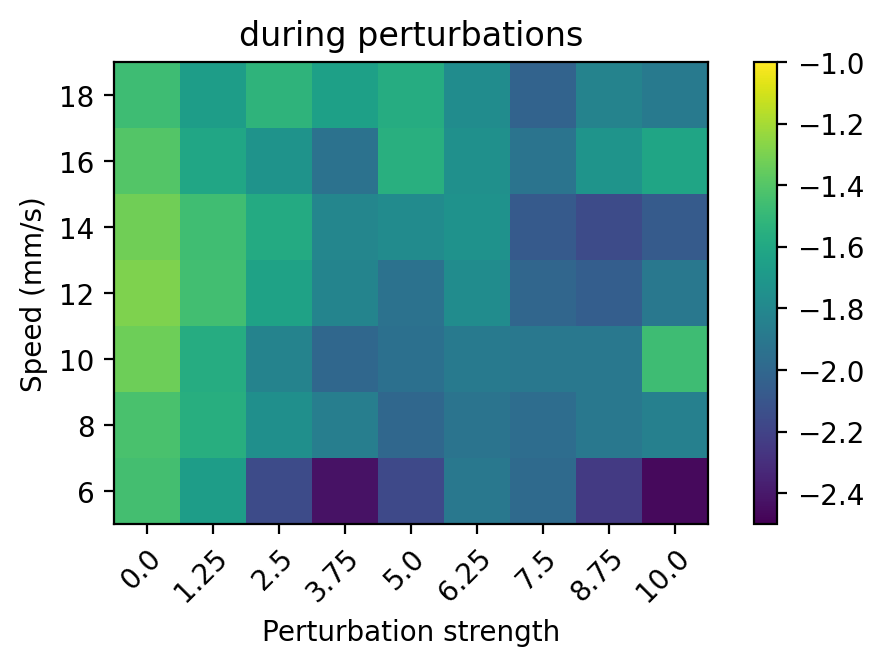

In [25]:
to_plot  = [
#     ("during - before perturbations", "during_diff_logpdf"),
#             ("after - before perturbations", "after_diff_logpdf"),
#             ("before perturbations", "before_logpdf"),
            ("during perturbations", "during_logpdf"),
#             ("after perturbations", "after_logpdf")
            ]


for (name, key) in to_plot:
    dimg = dgroup.reset_index().pivot(columns='perturbation', index='forward_speed', values=key)
    plt.figure(figsize=(6, 3), dpi=200)
    plt.imshow(dimg)
    if "diff" in key:
        plt.imshow(dimg, vmin=-3, vmax=0)
    else:
        plt.imshow(dimg, vmin=-2.5, vmax=-1)

    ax = plt.gca()
    ax.set_xticks(np.arange(len(dimg.columns)), labels=dimg.columns)
    ax.set_yticks(np.arange(len(dimg.index)), labels=np.int32(dimg.index))

    ax.invert_yaxis()

    ax.set_xlabel("Perturbation strength")
    ax.set_ylabel("Speed (mm/s)")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.colorbar()
    plt.title(name)

    plt.savefig('plots/fig_speeds_perturbation_impulse_logpdf_{}.pdf'.format(key), bbox_inches = "tight")